In [1]:
from keras.layers import Input, Dense, Layer, InputSpec
from keras.models import Model, load_model
from keras import Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from numpy.random import seed
import tensorflow as tf
random_seed = 224
tf.random.set_random_seed(random_seed)
seed(random_seed)

from sklearn import decomposition
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr 
from scipy.spatial.distance import pdist

%matplotlib inline


Using TensorFlow backend.


In [2]:
ccle_cancer = pd.read_csv('ccle_cancer_genes.csv', index_col = 0)

In [3]:
ccle_cancer.head()

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,8.59,3.47,0.03,0.06,0.03,0.00,0.01,0.00,0.00,0.00,...,0.00,0.02,0.26,0.00,0.00,0.01,0.01,0.00,0.06,0.00
ABI1,32.72,36.33,11.63,16.23,25.93,22.24,49.43,21.58,24.33,30.81,...,81.04,18.41,17.76,24.13,44.76,47.75,20.85,22.50,33.14,22.98
ABL1,23.42,19.91,18.94,16.63,34.06,43.88,20.07,19.68,20.83,32.83,...,14.14,36.24,14.35,15.60,31.47,90.36,46.23,35.38,12.57,15.08
ABL2,7.24,8.99,10.96,7.26,14.27,19.24,17.70,9.71,12.04,6.82,...,4.52,3.70,5.68,5.80,15.55,25.66,22.05,10.29,7.95,8.01
ACKR3,0.09,0.11,0.27,0.11,3.88,39.95,2.08,0.19,0.06,0.03,...,0.28,0.29,50.29,23.42,0.32,44.41,24.23,0.53,1.58,2.93


In [4]:
ccle_cancer.shape

(687, 1019)

In [5]:
# X = ccle_cancer.T.values

In [6]:
cacner_types = pd.Series([c.split('_')[-1] for c in ccle_cancer.T.index])

In [7]:
# remove cancer types with small number of samples (n<20)
th= cacner_types.value_counts()>=20
important_cancer_types= th[th==True].index
ind = cacner_types.isin(important_cancer_types)
important_cancer_types

Index([u'TISSUE', u'LUNG', u'SYSTEM', u'TRACT', u'INTESTINE', u'BREAST',
       u'SKIN', u'OVARY', u'PANCREAS', u'STOMACH', u'FIBROBLAST', u'KIDNEY',
       u'ENDOMETRIUM', u'OESOPHAGUS', u'LIVER', u'BONE'],
      dtype='object')

In [8]:
ccle_cancer = ccle_cancer.loc[:,ind.values]

In [9]:
ccle_cancer.shape

(687, 969)

In [10]:
Y=cacner_types[ind]
X= ccle_cancer.T.values
samples = ccle_cancer.T.index

In [11]:
print Y.shape, X.shape

(969,) (969, 687)


In [12]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
#PCA
pca = decomposition.PCA(n_components=50)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [14]:
X_pca.shape

(969, 50)

In [15]:
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.565723214032


In [16]:
# autoencoder
nb_epoch = 100
batch_size = 30
input_dim = X_scaled.shape[1]  
encoding_dim = 50
learning_rate = 1e-3

encoder1 = Dense(100, activation="elu", input_shape=(input_dim,), use_bias = True) 
encoder2 = Dense(50, activation="elu", use_bias = True) 
encoder3 = Dense(encoding_dim, activation="linear", use_bias = True, name = 'hidden_repr') 

decoder1 = Dense(50, activation="elu", use_bias = True)
decoder2 = Dense(100, activation="elu", use_bias = True)
decoder3 = Dense(input_dim, activation="linear", use_bias = True)

autoencoder = Sequential()
autoencoder.add(encoder1)
autoencoder.add(encoder2)
autoencoder.add(encoder3)

autoencoder.add(decoder1)
autoencoder.add(decoder2)
autoencoder.add(decoder3)


autoencoder.compile(
                    loss='mean_squared_error',
                    optimizer='adam')
autoencoder.summary()

autoencoder.fit(X_scaled, X_scaled, epochs=nb_epoch,batch_size=batch_size,shuffle=True, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               68800     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
hidden_repr (Dense)          (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_5 (Dense)              (None, 687)               69387     
Total params: 153,437
Trainable params: 153,437
Non-trainable params: 0
_________________________________________________________________
Epoc

In [17]:
encoder_model = Model(autoencoder.input, autoencoder.get_layer('hidden_repr').output)
X_ae= encoder_model.predict(X_scaled)

In [18]:
X_ae.shape

(969, 50)

# Visualize the hidden representation of PCA and Autoencoder using t-SNE

In [19]:

def get_tsne(X_in):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    X_in_tsne = tsne.fit_transform(X_in)
    X_in_tsne_df = pd.DataFrame(X_in_tsne, index=samples, columns=['tsne0', 'tsne1'])
    X_in_tsne_df['cancer_type'] = Y.values
    return X_in_tsne_df


In [20]:
def plot_tsne(data):
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x='tsne0', y='tsne1',
        hue="cancer_type",
        palette=sns.color_palette("hls", len(X_pca_tsne_df.cancer_type.unique())),
        data=data,
        legend="full",
    #     alpha=0.3
    )

In [21]:
X_pca_tsne_df = get_tsne(X_pca)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 969 samples in 0.001s...
[t-SNE] Computed neighbors for 969 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 969 / 969
[t-SNE] Mean sigma: 5.294447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.550224
[t-SNE] KL divergence after 300 iterations: 1.018579


In [22]:
X_ae_tsne_df = get_tsne(X_ae)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 969 samples in 0.002s...
[t-SNE] Computed neighbors for 969 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 969 / 969
[t-SNE] Mean sigma: 4.582041
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.532768
[t-SNE] KL divergence after 300 iterations: 1.009054


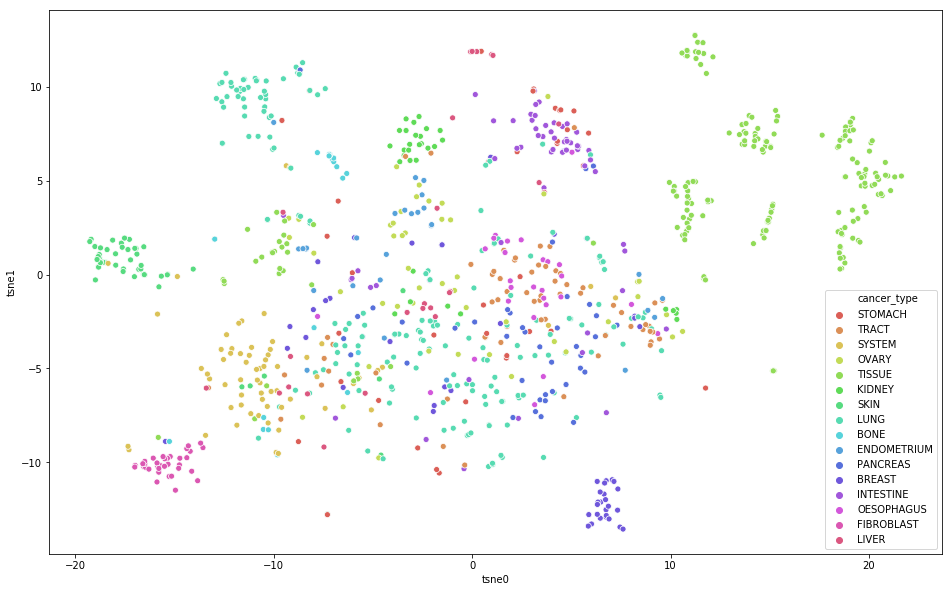

In [23]:
plot_tsne(X_pca_tsne_df)


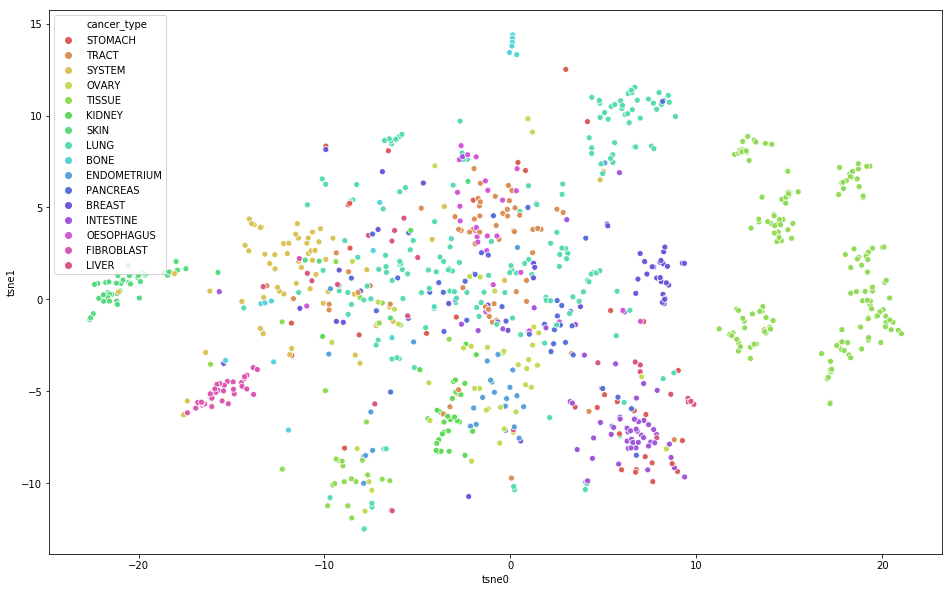

In [24]:
plot_tsne(X_ae_tsne_df)


# Visualize distance in the orgininal and reduced domains

In [25]:
#distance between all samples in the original domain
original_dist = pdist(X_scaled)
original_dist.shape

(468996,)

In [26]:
#distance between all samples in the PCA domain
pca_dist = pdist(X_pca)

In [27]:
#distance between all samples in the Autoencoder hidden layer domain
ae_dist = pdist(X_ae)

(0.9409101314087817, 0.0)


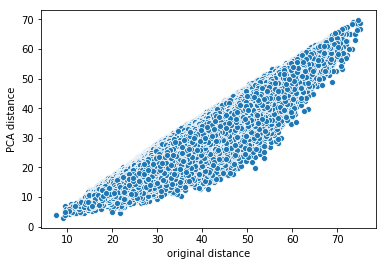

In [28]:
sns.scatterplot(x=original_dist, y=pca_dist)

plt.xlabel('original distance')
plt.ylabel('PCA distance')
print pearsonr(original_dist, pca_dist)

(0.9228890388662874, 0.0)


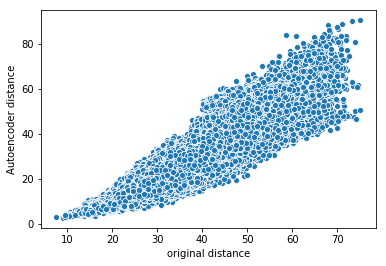

In [29]:
sns.scatterplot(x=original_dist, y=ae_dist)
plt.xlabel('original distance')
plt.ylabel('Autoencoder distance')
print pearsonr(original_dist, ae_dist)